# Multiprocessing


In this lab you will learn a little about multiprocessing in python. For most of the lab we will be using the "multiproess" packaage rather than multiprocessing. The python kermel interferes with the multiproessing module.

## Thread

You can think of threads as a dumb, new program that by default knows nothing about the rest of our code. We can create this new worker using the "Process" function. We give the process a function to run and potentially arguments to that function.  We use the "start" function to tell the thread to begin and the "join" function when we want the thread to end.


In [4]:
import numpy as np

In [1]:
import multiprocessing
import time 
def wait_arround():
    time.sleep(3)
    
process=multiprocessing.Process(target=wait_arround,args=())
process.start()
starttime = time.time()
process.join()
print(time.time()-starttime)

3.007272481918335


In the following cell start three different threads, all doing different tasks and join them at the end. In addition use the args parameter. For example I could have passed in the number of seconds to sleep in the above example.

In [3]:
# So I looked online and found a creative way to communicate between processes
# For example you can use .queue to send messages between processes
# seperate process #1 (send message A to second process)
def process_A(queue):
    print("Process A Sending Message to Process B")
    queue.put("Knock Knock")
    message = queue.get()
    print(f"Process A Received message '{message}' from Process C.")

def process_B(queue):
    message = queue.get()
    print(f"Process B Received message '{message}' from Process A.")
    print("Process B is sending 'Who's there?' to Process C.")
    queue.put("Who's there?")

def process_C(queue):
    message = queue.get()
    print(f"Process C Received message '{message}' from Process B.")
    print("Process C is sending 'Boo!' to Process A.")
    queue.put("Boo!")

queue = multiprocessing.Queue()

threads = []

threads.append(multiprocessing.Process(target=process_A, args=(queue,)))
threads.append(multiprocessing.Process(target=process_B, args=(queue,)))
threads.append(multiprocessing.Process(target=process_C, args=(queue,)))

for thread in threads:
    thread.start()

queue.put("Knock Knock")

for thread in threads:
    thread.join()

Process A Sending Message to Process B
Process B Received message 'Knock Knock' from Process A.
Process B is sending 'Who's there?' to Process C.Process A Received message 'Knock Knock' from Process C.

Process C Received message 'Who's there?' from Process B.
Process C is sending 'Boo!' to Process A.


## Locks

Remember, each thread run completely independently.  This can cause problems. In the example below we are running three threads. Each thread is accessing the same file and updates it content by one.  Given that each thread is updating it by 1, the final result should be 3000. Run this cell several times and examine the result.


In [ ]:
import multiprocessing

fl=open("num.txt","w")
fl.write("0")
fl.close()

def process_function():
    for i in range(1000):
        fl=open("num.txt")
        v=int(fl.read().strip())+1
        fl.close()
        fl=open("num.txt","w")
        fl.write(str(v))
        fl.close()


process_1 = multiprocessing.Process(target=process_function, args=())
process_2 = multiprocessing.Process(target=process_function, args=())
process_3= multiprocessing.Process(target=process_function, args=())

process_1.start()
process_2.start()
process_3.start()
process_1.join()
process_2.join()
process_3.join()


fl=open("num.txt")
print(fl.read())

You likely saw an error when running the cell. What do you think is going on?
**It seems multiple processes are trying to access and modify the same file "num.txt" when we call process function in multiple threads. This is leading to data corruption because each thread is probably overwriting anything the other thread was able to modify.**

The call multiprocess.Lock() return a lock object.  A process can ask to acquire a lock. Once it has acquired a lock it can proceed to the next line of the code. All other threads will pause until the can acquire the lock. Copy the code above into the next cell. Create a lock and then pass that lock object as an argument to the process_function. Figure out where to put the locks (inside the for loop) so you get the correct result.

In [ ]:
import multiprocessing

fl=open("num.txt","w")
fl.write("0")
fl.close()

def process_function(lock):
    for i in range(1000):
        with lock:
            fl=open("num.txt")
            v=int(fl.read().strip())+1
            fl.close()
            fl=open("num.txt","w")
            fl.write(str(v))
            fl.close()

lock = multiprocessing.Lock()

process_1 = multiprocessing.Process(target=process_function, args=(lock,))
process_2 = multiprocessing.Process(target=process_function, args=(lock,))
process_3= multiprocessing.Process(target=process_function, args=(lock, ))

process_1.start()
process_2.start()
process_3.start()
process_1.join()
process_2.join()
process_3.join()


fl=open("num.txt")
print(fl.read())

Calculate the time it takes to run your new improved cell.  Modify your code so a single thread, requiring no locks, does the same taks.  Document your results. You should see that the code with three threads is signficantly longer.  Locks are quite expensive and need to be used sparinly, but in some cases are necessary.


In [ ]:
import multiprocessing

fl=open("num.txt","w")
fl.write("0")
fl.close()

def process_function(lock):
    for i in range(1000):
        with lock:
            fl=open("num.txt")
            v=int(fl.read().strip())+1
            fl.close()
            fl=open("num.txt","w")
            fl.write(str(v))
            fl.close()
            
def single_thread_no_lock_process_function():
    for i in range(1000):
            fl=open("num.txt")
            v=int(fl.read().strip())+1
            fl.close()
            fl=open("num.txt","w")
            fl.write(str(v))
            fl.flush()
            fl.close()

# Start the time for three threads 
start_time = time.time()

lock = multiprocessing.Lock()

process_1 = multiprocessing.Process(target=process_function, args=(lock,))
process_2 = multiprocessing.Process(target=process_function, args=(lock,))
process_3 = multiprocessing.Process(target=process_function, args=(lock,))

process_1.start()
process_2.start()
process_3.start()
process_1.join()
process_2.join()
process_3.join()

# Document output of three thread
out = open("num.txt")
print(f"Three Thread Output: {out.read()}")

three_thread_time = time.time() - start_time 
print(f'Three Thread Time: {three_thread_time}')

# Start time for a single thread

start_time = time.time()

single_thread_no_lock_process_function()

out = open("num.txt")
print(f"Single Thread Output: {out.read()}")

single_thread_time = time.time() - start_time 
print(f"Single Thread Time: {single_thread_time}")

print(f"Difference in time between single and three threads with a lock: {three_thread_time - single_thread_time}")

## Pool

The multiprocessing library in Python provides a Pool class that can be used to create a pool of worker processes. A pool of worker processes can be used to perform computations in parallel, which can significantly speed up the execution time of a program.

The Pool class can be used to create a pool of worker processes in the following way:


In [ ]:
import time
def dummy(sleepTime):
    time.sleep(sleepTime)
with multiprocess.Pool(4) as pool:
    # Code that uses the pool of worker processes goes here
     pool.map(dummy, [3, 1, 3, 4])


In this example, a pool of 4 worker processes is created. The with statement is used to ensure that the pool is properly closed and all worker processes are terminated when the block of code is finished executing.

Once a pool of worker processes has been created, it can be used to perform computations in parallel using the following methods:

apply(func, args, kwds): applies the function func to the arguments args and keyword arguments kwds using one of the worker processes in the pool. The method blocks until the result is returned.

apply_async(func, args, kwds, callback): applies the function func to the arguments args and keyword arguments kwds using one of the worker processes in the pool. The method returns immediately and the result is returned using the callback function.

map(func, iterable, chunksize): applies the function func to each element of the iterable in parallel, using the worker processes in the pool. The chunksize argument can be used to control the number of items to be processed by each worker at a time. The method blocks until the result is returned.

map_async(func, iterable, chunksize, callback): applies the function func to each element of the iterable in parallel, using the worker processes in the pool. The chunksize argument can be used to control the number of items to be processed by each worker at a time. The method returns immediately and the result is returned using the callback function.




### Problem
In the next cell is python code to caclulate pi. Using  multiprocces module parallelize the calculation.  You might want to also modify the function using what you've learned in class to run more efficiently.

In [ ]:
import random
def calculate_pi(n_points):
    count_points_in_circle = 0
    for _ in range(n_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            count_points_in_circle += 1
    return 4 * count_points_in_circle / n_points

def calculate_pi_in_parallel_map_async(n_points, n_workers):
    pool = multiprocessing.Pool(n_workers)
    result = pool.map_async(calculate_pi, [n_points//n_workers] * n_workers)
    pool.close()
    pool.join()
    return sum(result.get()) / n_workers

if __name__ == '__main__':
    n_points = 10000000
    n_workers = 4
    pi = calculate_pi_in_parallel_map_async(n_points, n_workers)
    print(pi)


In [ ]:
import random 

def calculate_pi(n_points):
    count_points_in_circle = 0
    for _ in range(n_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            count_points_in_circle += 1
    return 4 * count_points_in_circle / n_points

def calculate_pi_in_parallel(n_points, n_workers):
    pool = multiprocessing.Pool(n_workers)
    # need to input the function that the worker will work on as well as the number of times it will iterate through the function per worker (i.e the list)
    result = pool.map_async(calculate_pi, [n_points//n_workers] * n_workers) # need to input the function 
    pool.close()
    pool.join()
    return sum(result.get()) / n_workers

n_points = 10000
n_workers = 5
pi = calculate_pi_in_parallel(n_points, n_workers)
print(f'Estimated Pi with 5 workers: {pi}')

## The problem with GIL

The Global Interpreter Lock (GIL) is a mechanism in the CPython implementation of Python that prevents multiple native threads from executing Python bytecodes at once. This means that only one thread can execute Python code at a time, even on systems with multiple processors or cores. This can cause problems when trying to parallelize Python code, as it can limit the performance benefits of using multiple threads or processes.

For example, if you have a program that performs a computationally expensive task, such as image processing or numerical simulation, and you use multiple threads to perform the task in parallel, the GIL will prevent the threads from executing the Python code in parallel. Instead, the threads will be interleaved, with only one thread executing Python code at a time. This can result in poor performance and a slow execution time, even on systems with multiple processors or cores.

Additionally, Python libraries that are not written with thread safety in mind also can cause problems in parallelizing Python code. Many libraries use global variables or shared state in ways that are not thread-safe, which can lead to race conditions, data corruption, or other bugs when used in a multi-threaded environment.

However, the GIL does not affect the execution of C extension modules which can release the GIL during execution, allowing other threads to run. So, using libraries that utilize C extension modules (such as numba) can help to overcome this limitation.



## The pickling problem

When you create a new process through mechanisms such as pool or thread all of the arguments to the subprocess are pickled.

Pickling is the process of converting an object's state to a byte stream, which can then be stored or transmitted, and later reconstructed to create a new object with the same state. In the context of multiprocessing, pickling is used to pass objects between processes.

Pickling can slow down multiprocessing for several reasons:

Serialization overhead: The process of pickling an object to a byte stream, and later unpickling it to reconstruct the object, can add significant overhead to the execution time of a program. This overhead can be particularly pronounced when passing large or complex objects between processes.

Inter-process communication (IPC) overhead: Pickling and unpickling objects also adds overhead to inter-process communication (IPC), as the objects need to be serialized and transmitted between processes. This can slow down the overall performance of a program that uses multiprocessing.

Data duplication: When an object is pickled and sent to another process, a new copy of the object is created in the destination process. This can cause memory issues when passing large data structures.

Limited pickleability: Certain types of objects can not be pickled, such as functions, methods, and certain types of variables. This can make it difficult to pass these types of objects between processes, and can limit the functionality of multiprocessing.

Security risks: Pickling and unpickling data can also create security risks, as it can be used to execute malicious code.

### Problem

The above two issues can make some things nearly impossible to parallelize in python until recently. For example, imagine you need to caculate the traveltime from a many different point to a volume.  This often a necessary step in Kirchhoff migration.

The fast marching eikonal method is by far the fastest approach. In the next cell we will build a simple slowness model and then use the fast marching solver to caculate and plot the traveltimes. The way this module works also requires supply an array where all the values are 1 except at the source location.

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


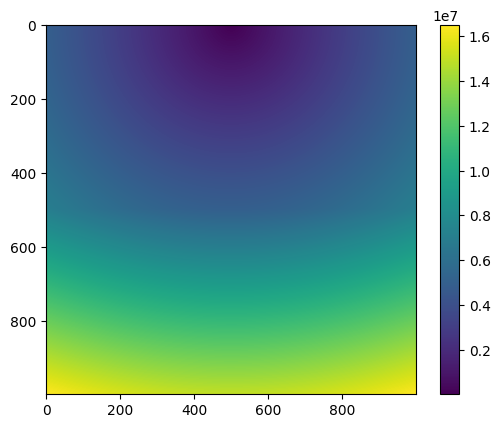

In [2]:
# !pip install scikit-fmm
!pip install scikit-fmm

import numpy as np
import skfmm
import matplotlib.pyplot as plt

def calcTimes(slow,src1,src2, ds):
    """
    slow - float array of slowness
    src1,src2 - Location of the source
    ds - sampling
    """
    
    phi=np.ones(ns)   # Create an array of 1s
    phi[src1,src2]=-1  #Set the source locationt
    return skfmm.travel_time(phi,slow,ds)  #calculate traveltimes


ns=[1000,1000]  #size of grid
div=int(ns[0]/2)  #middle of grid
slow=np.ndarray((ns))  #slowness
slow[:,:div]=1./2000  #top slowness
slow[:,div:]=1./4000   #bottom slowness
d=[5.,5.] #grid spacing


tt=calcTimes(slow,div,0,d)  #calculate traveltimes

plt.imshow(tt.T)
plt.colorbar()

What I would like to do is cacluate many travel time maps (don't execute the following cell because it will take a while but illustrates the point) and store it in an array.

In [7]:
def calcTmes(slow,isrc, ds,times):
    """
    slow - float array of slowness
    isr - Location of the source on the surface
    ds - sampling
    tt - Travel time
    """
    
    phi=np.ones(ns)   # Create an array of 1s
    phi[src1,src2]=-1  #Set the source locationt
    times[isrc,:,:]=skfmm.travel_time(phi,slow,ds)  #calculate traveltimes

tt=np.zeros(1000,1000,1000))
for i1 in range(1000):
    tmaps.append(calcTimes,i1,0,ds,tt)


Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/h

KeyboardInterrupt: 

KeyboardInterrupt
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._

(20, 20)
0
(20, 20)
1
(20, 20)
2
(20, 20)
3
(20, 20)
4


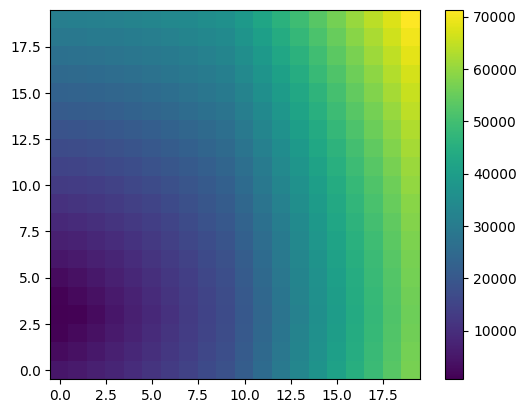

In [15]:
import matplotlib.pyplot as plt

def calcTimes(slow, isrc, ds, times):
    """
    slow - float array of slowness
    isrc - Location of the source on the surface
    ds - sampling
    times - array to store travel times
    """
    ns = slow.shape
    print(ns)
    phi = np.ones(ns)  # Create an array of 1s
    phi[isrc[0], isrc[1]] = -1  # Set the source location
    print(isrc[0])
    times[isrc[0], :, :] = skfmm.travel_time(phi, slow, dx=ds)  # calculate travel times

def test_calcTimes():
    # create a small slowness model
    ns = [20, 20]  # size of grid
    div = int(ns[0] / 2)  # middle of grid
    slow = np.ndarray(ns)  # slowness
    slow[:, :div] = 1. / 2000  # top slowness
    slow[:, div:] = 1. / 4000  # bottom slowness
    d = [1., 1.]  # grid spacing

    # create an array to store travel times
    nt = 5
    times = np.zeros((nt,) + tuple(ns))

    # calculate travel time maps
    for i in range(nt):
        isrc = (i, 0)  # source location on surface
        calcTimes(slow, isrc, d, times)

    # check the shape of the travel time maps
    assert times.shape == (nt,) + tuple(ns)
    
    # plot a travel time slice
    plt.imshow(times[3,:,:], origin='lower')
    plt.colorbar()
    plt.show()
    
test_calcTimes()


In [68]:
import numpy as np
import skfmm
import matplotlib.pyplot as plt
from multiprocessing import Pool

def calcTimes(slow, isrc, ds, times):
    """
    slow - float array of slowness
    isrc - Location of the source on the surface
    ds - sampling
    times - array to store travel times
    """
    ns = slow.shape
    phi = np.ones(ns)  # Create an array of 1s
    phi[isrc[0], isrc[1]] = -1  # Set the source location
    times[isrc[0], :, :] = skfmm.travel_time(phi, slow, dx=ds)  # calculate travel times

ns=[1000,1000]  #size of grid
div=int(ns[0]/2)  #middle of grid
slow=np.ndarray((ns))  #slowness
slow[:,:div]=1./2000  #top slowness
slow[:,div:]=1./4000   #bottom slowness
d=[5.,5.] #grid spacing

# Initialize empty array to hold travel time maps
tmaps = np.zeros((1000, 1000, 1000))

# Create a list of arguments for calcTimes to be passed to multiprocessing.Pool
arg_list = [(slow, (i1, 0), d, tmaps) for i1 in range(1000)]

# Define a function to run calcTimes with a tuple of arguments
def run_calcTimes(args):
    calcTimes(*args)

# Create a multiprocessing.Pool object with 4 processes (or fewer if memory is a concern)
with Pool(processes=4) as pool:
    # Use pool.starmap to call calcTimes with each set of arguments in arg_list
    pool.starmap(run_calcTimes, arg_list)

# Plot a sample travel time map
plt.imshow(tmaps[500,:,:].T)
plt.colorbar()


Process ForkPoolWorker-32069:
Process ForkPoolWorker-32067:
Process ForkPoolWorker-32070:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", 

EOFError: Ran out of input

  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-32065:
Traceback (most recent ca

Begin by using what you know about the pool function to create a parallel version of the above. Do not use above 4 threads because your are likely to run out of memory (and less if you run on your laptop) why?

**We shouldnt use more than 4 threads is due to memory constraints. We have to use the multiprocessing module to parallelize the "calcTimes" function across 1000 rows of the slow array. The "pool" object will create 4 proceses, where each process will be running in parrallel so that we execute the function more efficiently. Each process will generate its own tmaps array, which is size 1000x1000x1000 before passing it to calcTimes. Since tmaps is very large, using more than 4 processes can definitely exceed the available memory and cause the program to crash or run forever. "slow" will also contribute to memory as well which is 1000x1000. So in order to avoid running out of memory, staying to 4 threads makes the most sense here.**

There are three challenges parallelizing the above.  The largest is the times array in which every thread is attempting to fill in different parts. What actually happened when you parallelized in the manner?


**Based on how I parallized the code, I created a pool object with 4 processes and called the calcTimes function to calculate the travel time for the slowness model slice with different sets of arguments for each process. Each process corresponds to a different row or slice of th slowness array to fill in the tmaps array which will be our output. Like I said above, the challenge of parralizing the code is tmaps large, so generating multiple copies of it can exceed the memory limits. But what is really probably going on is without appropriate locking mechanisms, it is possible that the different processes may overwrite each other's changes to the tmaps array, resulting in incorrect or inconsistent results. This can happen, for example, if two processes attempt to update the same element in the tmaps array simultaneously. These types of race and synchronization issues are very frustrating, as we must try to use the appropriate locking mechanisms to make sure that only one process accesses a particular part of the array at a time.**

The code you generated issue is that each spawned thread would make a pickled version of the slowness array. A third, more minor issue, is that the phi array is being reallocted 100 times in the above loop. Ideally it should be allocated once per thread, not once per job.

In Python, the multiprocessing module provides support for parallel execution of code using multiple processes. The RawArray class from this module can be used to create a shared memory array that can be accessed by multiple processes. This allows for efficient communication and data sharing between processes, as the data is stored in a shared memory segment that can be accessed directly by all processes, rather than being copied between them. This can be useful when working with large amounts of data or when performing computationally expensive operations that can be parallelized.

The following code shows how to create a raw array and wrap it into a numpy array.

In [ ]:
rawArray=multiprocess.RawArray("d",1000*1000)
numpyArray=np.frombuffer(rawArray).reshape(1000,1000)


If a rawArray is accessed by a thread the pickle function will not be called. You should be able to take advantageous of this fact to signficantly speed up.

You can also improve your code with the way you handle the phi variable.  Change your code to allocate phi as a 3-d array (nthreads,1000,1000) and use the multiprocess.current_process() function to index correctly into the array.

In [16]:
import numpy as np
import skfmm
import matplotlib.pyplot as plt
from multiprocessing import Pool, current_process, RawArray

def calcTimes(slow, isrc, ds, times, phi):
    """
    slow - float array of slowness
    isrc - Location of the source on the surface
    ds - sampling
    times - array to store travel times
    """
    ns = slow.shape
    phi[current_process()._identity[0]-1,:,:] = np.ones(ns) # Set the thread's phi array to an array of 1s
    phi[current_process()._identity[0]-1,isrc[0], isrc[1]] = -1 # Set the source location in the thread's phi array
    times[isrc[0], :, :] = skfmm.travel_time(phi[current_process()._identity[0]-1], slow, dx=ds) # calculate travel times using the thread's phi array

ns=[1000,1000] #size of grid
div=int(ns[0]/2) #middle of grid
slow=np.ndarray((ns)) #slowness
slow[:,:div]=1./2000 #top slowness
slow[:,div:]=1./4000 #bottom slowness
d=[5.,5.] #grid spacing

# Initialize empty array to hold travel time maps
tmaps = np.zeros((1000, 1000, 1000))

# Create a RawArray of doubles to hold the phi arrays for each thread
phi_array = RawArray("d", 1000*1000*4)
phi = np.frombuffer(phi_array).reshape(4, 1000, 1000)

# Create a list of arguments for calcTimes to be passed to multiprocessing.Pool
arg_list = [(slow, (i1, 0), d, tmaps, phi) for i1 in range(1000)]

# Define a function to run calcTimes with a tuple of arguments
def run_calcTimes(args):
    calcTimes(*args)

# Create a multiprocessing.Pool object with 4 processes (or fewer if memory is a concern)
with Pool(processes=4) as pool:
    # Use pool.starmap to call calcTimes with each set of arguments in arg_list
    pool.starmap(run_calcTimes, arg_list)

# Plot a sample travel time map
plt.imshow(tmaps[500,:,:].T)
plt.colorbar()






Process ForkPoolWorker-29:
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/spack/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.5.0/python-3.10.8-tye3styllri3xiql6psptyz7uujbz4hn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target

EOFError: Ran out of input

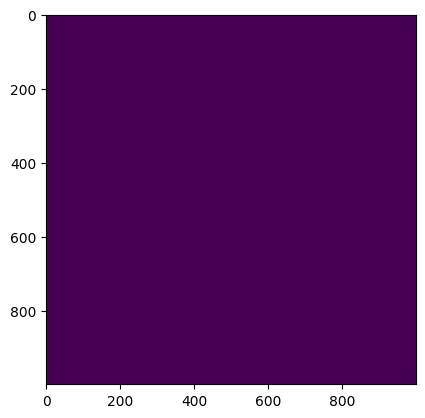

In [8]:
plt.imshow(tmaps[600,:,:])

In [40]:
import numpy as np
import skfmm
import matplotlib.pyplot as plt
from multiprocessing import Pool, current_process, sharedctypes

def calcTimes(slow, isrc, ds, times, phi, index):
    """
    slow - float array of slowness
    isrc - Location of the source on the surface
    ds - sampling
    times - array to store travel times
    phi - shared array for phi values
    index - index of the current process
    """
    ns = slow.shape
    phi = np.frombuffer(phi).reshape((1, ns[0], ns[1]))
    phi[index, :, :] = np.ones(ns)
    phi[index, isrc[0], isrc[1]] = -1
    times[index, :, :] = skfmm.travel_time(phi[index, :, :], slow, dx=d)

ns=[1000,1000] #size of grid
div=int(ns[0]/2) #middle of grid
slow=np.ndarray((ns)) #slowness
slow[:,:div]=1./2000 #top slowness
slow[:,div:]=1./4000 #bottom slowness
d=[5.,5.] #grid spacing

# Initialize empty array to hold travel time maps
tmaps = np.zeros((1, 1000, 1000))

# Create a shared array for phi values
phi = sharedctypes.RawArray('d', 1*1000*1000)
phi_arr = np.frombuffer(phi).reshape((1, ns[0], ns[1]))
phi_arr[:] = 1

# Create a list of arguments for calcTimes to be passed to multiprocessing.Pool
arg_list = [(slow, (i1, 0), d, tmaps, phi, i) for i, i1 in enumerate(range(1000))]

# Define a function to run calcTimes with a tuple of arguments
def run_calcTimes(args):
    calcTimes(*args)

# Create a multiprocessing.Pool object with 4 processes (or fewer if memory is a concern)
with Pool(processes=1) as pool:
    # Use pool.map to call calcTimes with each set of arguments in arg_list
    pool.map(run_calcTimes, arg_list)

# Plot a sample travel time map
plt.imshow(tmaps[0,:,:].T)
plt.colorbar()




RuntimeError: c_double_Array_1000000 objects should only be shared between processes through inheritance